# <center>  Lending Club Fraud Detection using XGboosting
### <center> Ziyi Lu, Aug-Sep 2019$^*$
     * Lu: Department of Applied Economics, University of Wisconsing Madison.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# !pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import timeit
import matplotlib
# !pip install graphviz
import graphviz

In [2]:
df_full = pd.read_csv("C:/Users/luziy/Documents/datacamp/notes/FinTech/data/df_full_clean.csv")

pd.set_option('display.max_columns', 999)
df_full.head()

,id,loanamnt,intrate,installment,grade,subgrade,emplength,annualinc,issued,dti,delinq2yrs,ficorangelow,ficorangehigh,inqlast6mths,mthssincelastdelinq,openacc,pubrec,revolbal,revolutil,totalacc,totcollamt,totcurbal,totalrevhilim,accopenpast24mths,avgcurbal,bcopentobuy,bcutil,mosinoldilacct,mosinoldrevtlop,mosinrcntrevtlop,mosinrcnttl,mortacc,mthssincerecentbc,mthssincerecentinq,mthssincerecentrevoldelinq,numacctsever120pd,numactvbctl,numactvrevtl,numbcsats,numbctl,numiltl,numoprevtl,numrevaccts,numrevtlbalgt0,numsats,numtl90gdpd24m,numtloppast12m,pcttlnvrdlq,percentbcgt75,pubrecbankruptcies,taxliens,tothicredlim,totalbalexmort,totalbclimit,totalilhighcreditlimit,loanstatus,flag,emptitle_freq,addrstate_freq,crhist,homeownership_MORTGAGE,homeownership_OWN,homeownership_RENT,initialliststatus_f,initialliststatus_w,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_other
0,67275481,20000.0,8.49,631.26,2,6,10.0,85000.0,12,17.61,1.0,705.0,709.0,0,3.0,8.0,0,826.0,5.7,15.0,0.0,141601.0,14500.0,4.0,17700.0,13674.0,5.7,149.0,55.0,32.0,13.0,3.0,32.0,8.0,NaN,1.0,2.0,2.0,3.0,3.0,9.0,3.0,3.0,2.0,8.0,1,0.0,93.3,0.0,0,0,193390.0,27937.0,14500.0,36144.0,1.0,train,6.0,3182,16.0,1,0,0,0,1,0,0,0,1
1,68596180,20000.0,5.32,602.30,1,1,9.0,65000.0,12,18.83,0.0,835.0,839.0,1,NaN,12.0,0,2269.0,3.0,17.0,0.0,15444.0,76200.0,2.0,1287.0,73931.0,3.0,63.0,295.0,19.0,15.0,0.0,19.0,4.0,NaN,0.0,3.0,3.0,10.0,11.0,4.0,10.0,13.0,3.0,12.0,0,0.0,100.0,0.0,0,0,106217.0,15444.0,76200.0,30017.0,1.0,train,1026.0,23398,24.0,0,1,0,0,1,0,1,0,0
2,68616873,8000.0,11.48,263.74,2,10,10.0,42000.0,12,34.80,0.0,700.0,704.0,0,75.0,8.0,0,7034.0,39.1,18.0,0.0,199696.0,18000.0,5.0,28528.0,9966.0,41.4,155.0,253.0,15.0,10.0,1.0,50.0,10.0,NaN,1.0,3.0,3.0,3.0,6.0,5.0,5.0,11.0,3.0,8.0,0,2.0,94.4,33.3,0,0,256513.0,113782.0,17000.0,135513.0,1.0,train,1.0,1228,21.0,1,0,0,0,1,1,0,0,0
3,68466961,28000.0,6.49,858.05,1,2,10.0,92000.0,12,21.60,0.0,720.0,724.0,0,42.0,16.0,0,51507.0,64.5,24.0,0.0,221110.0,79900.0,1.0,13819.0,16623.0,59.9,82.0,379.0,19.0,19.0,2.0,19.0,NaN,42.0,0.0,7.0,9.0,9.0,11.0,4.0,13.0,18.0,9.0,16.0,0,0.0,91.7,22.2,0,0,304003.0,74920.0,41500.0,42503.0,1.0,train,234.0,7649,31.0,1,0,0,0,1,0,1,0,0
4,67715283,16000.0,12.88,538.18,3,12,10.0,65000.0,12,18.96,0.0,675.0,679.0,0,33.0,7.0,1,5157.0,54.3,20.0,1830.0,39781.0,9500.0,2.0,5683.0,3684.0,21.6,256.0,360.0,1.0,1.0,0.0,1.0,14.0,33.0,1.0,3.0,5.0,3.0,3.0,12.0,5.0,7.0,5.0,7.0,0,2.0,80.0,0.0,0,1,80999.0,39781.0,4700.0,71499.0,0.0,train,1.0,3376,30.0,1,0,0,0,1,0,0,0,1


In [3]:
# should change the encoding from the previous script
df_full = df_full.drop("id", axis = 1)

a = np.repeat(0, df_full.shape[0])
a[df_full.loanstatus == 0 ] = 1

df_full.loanstatus = a

df_full.loanstatus.value_counts()

0    225217
1     39863
Name: loanstatus, dtype: int64

In [7]:
df_train =  df_full.loc[df_full.flag == "train" , : ]

df_train = df_train.drop( "flag", axis = 1 )
df_train.shape

(265064, 67)

In [4]:
df_test =  df_full.loc[df_full.flag == "test" , : ]
df_test = df_test.drop( "flag", axis = 1 )
df_test.shape

(16, 67)

In [8]:
x_tr, x_t, y_tr, y_t = train_test_split(df_train.drop('loanstatus', axis = 1), df_train.loanstatus, 
                                                      test_size=0.3, random_state=2016, stratify = df_train.loanstatus )

# train_dmt = xgb.DMatrix(data = x_t, label = y_t, missing = np.NAN)
# valid_dmt = xgb.DMatrix(data = x_tr, label = y_tr, missing = np.NAN)

C:\Users\luziy\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


**benchmark model**

In [7]:
# becnmark
# benchmark model

spw = sum(y_tr ==0 ) / sum(y_tr ==1 )
bst_benchmark = xgb.XGBClassifier( scale_pos_weight = spw )

bst_benchmark.fit(x_tr, y_tr )

y_t_pred = bst_benchmark.predict(x_t) 

print(pd.Series(y_t_pred).value_counts())

print (metrics.classification_report(y_t, y_t_pred))

print(metrics.recall_score(y_t, y_t_pred))

print(metrics.accuracy_score(y_t, y_t_pred))

0    45161
1    34359
dtype: int64
              precision    recall  f1-score   support

           0       0.92      0.61      0.73     67561
           1       0.24      0.68      0.35     11959

    accuracy                           0.62     79520
   macro avg       0.58      0.65      0.54     79520
weighted avg       0.81      0.62      0.68     79520

0.6802408228112719
0.6221327967806841


**hyperparameter tuning**

In [9]:
param = { "scale_pos_weight" : [3.5, 4, 4.5, 5] , "max_depth": [3 ,4, 5], "min_child_weight": [10, 15, 20] , 
          'colsample_bytree': (0.2, 0.25, 0.3), 'subsample': (0.5, 0.75, 1), 'gamma': (0, 0.5, 1) }

In [11]:
bst = xgb.XGBClassifier(learning_rate=0.05, n_estimators=500,  objective = 'binary:logistic' , early_stopping_rounds=30  )

In [12]:
folds = 3
param_comb = 100
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

In [13]:
clf = RandomizedSearchCV(bst, param, n_jobs=1, n_iter=param_comb,
                   cv=skf.split(x_tr,y_tr) ,                     
                   verbose=2, refit=True, scoring = "f1" )

In [14]:
start = timeit.timeit()
clf.fit(x_tr, y_tr )
end = timeit.timeit()
print(end - start)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] subsample=0.75, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.75, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.3, total= 2.8min
[CV] subsample=0.75, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s


[CV]  subsample=0.75, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.3, total= 2.8min
[CV] subsample=0.75, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.3 
[CV]  subsample=0.75, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.3, total= 2.8min
[CV] subsample=0.5, scale_pos_weight=4.5, min_child_weight=15, max_depth=5, gamma=0, colsample_bytree=0.3 
[CV]  subsample=0.5, scale_pos_weight=4.5, min_child_weight=15, max_depth=5, gamma=0, colsample_bytree=0.3, total= 2.9min
[CV] subsample=0.5, scale_pos_weight=4.5, min_child_weight=15, max_depth=5, gamma=0, colsample_bytree=0.3 
[CV]  subsample=0.5, scale_pos_weight=4.5, min_child_weight=15, max_depth=5, gamma=0, colsample_bytree=0.3, total= 3.0min
[CV] subsample=0.5, scale_pos_weight=4.5, min_child_weight=15, max_depth=5, gamma=0, colsample_bytree=0.3 
[CV]  subsample=0.5, scale_pos_weight=4.5, min_child_weight=15, max_depth=5

[CV]  subsample=0.75, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=1, colsample_bytree=0.2, total= 2.1min
[CV] subsample=0.75, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=1, colsample_bytree=0.2 
[CV]  subsample=0.75, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=1, colsample_bytree=0.2, total= 2.0min
[CV] subsample=0.75, scale_pos_weight=4, min_child_weight=20, max_depth=4, gamma=1, colsample_bytree=0.3 
[CV]  subsample=0.75, scale_pos_weight=4, min_child_weight=20, max_depth=4, gamma=1, colsample_bytree=0.3, total= 2.1min
[CV] subsample=0.75, scale_pos_weight=4, min_child_weight=20, max_depth=4, gamma=1, colsample_bytree=0.3 
[CV]  subsample=0.75, scale_pos_weight=4, min_child_weight=20, max_depth=4, gamma=1, colsample_bytree=0.3, total= 2.2min
[CV] subsample=0.75, scale_pos_weight=4, min_child_weight=20, max_depth=4, gamma=1, colsample_bytree=0.3 
[CV]  subsample=0.75, scale_pos_weight=4, min_child_weight=20, max_depth=4, gamma=1, c

[CV]  subsample=0.5, scale_pos_weight=3.5, min_child_weight=15, max_depth=5, gamma=0.5, colsample_bytree=0.2, total= 2.1min
[CV] subsample=0.5, scale_pos_weight=3.5, min_child_weight=15, max_depth=5, gamma=0.5, colsample_bytree=0.2 
[CV]  subsample=0.5, scale_pos_weight=3.5, min_child_weight=15, max_depth=5, gamma=0.5, colsample_bytree=0.2, total= 2.1min
[CV] subsample=0.75, scale_pos_weight=5, min_child_weight=15, max_depth=3, gamma=1, colsample_bytree=0.25 
[CV]  subsample=0.75, scale_pos_weight=5, min_child_weight=15, max_depth=3, gamma=1, colsample_bytree=0.25, total= 1.7min
[CV] subsample=0.75, scale_pos_weight=5, min_child_weight=15, max_depth=3, gamma=1, colsample_bytree=0.25 
[CV]  subsample=0.75, scale_pos_weight=5, min_child_weight=15, max_depth=3, gamma=1, colsample_bytree=0.25, total= 1.7min
[CV] subsample=0.75, scale_pos_weight=5, min_child_weight=15, max_depth=3, gamma=1, colsample_bytree=0.25 
[CV]  subsample=0.75, scale_pos_weight=5, min_child_weight=15, max_depth=3, ga

[CV]  subsample=0.5, scale_pos_weight=4, min_child_weight=10, max_depth=3, gamma=0, colsample_bytree=0.2, total= 1.6min
[CV] subsample=1, scale_pos_weight=4, min_child_weight=10, max_depth=4, gamma=0, colsample_bytree=0.25 
[CV]  subsample=1, scale_pos_weight=4, min_child_weight=10, max_depth=4, gamma=0, colsample_bytree=0.25, total= 1.8min
[CV] subsample=1, scale_pos_weight=4, min_child_weight=10, max_depth=4, gamma=0, colsample_bytree=0.25 
[CV]  subsample=1, scale_pos_weight=4, min_child_weight=10, max_depth=4, gamma=0, colsample_bytree=0.25, total= 1.8min
[CV] subsample=1, scale_pos_weight=4, min_child_weight=10, max_depth=4, gamma=0, colsample_bytree=0.25 
[CV]  subsample=1, scale_pos_weight=4, min_child_weight=10, max_depth=4, gamma=0, colsample_bytree=0.25, total= 1.8min
[CV] subsample=0.5, scale_pos_weight=5, min_child_weight=20, max_depth=4, gamma=0, colsample_bytree=0.3 
[CV]  subsample=0.5, scale_pos_weight=5, min_child_weight=20, max_depth=4, gamma=0, colsample_bytree=0.3, 

[CV]  subsample=0.75, scale_pos_weight=5, min_child_weight=20, max_depth=3, gamma=0, colsample_bytree=0.25, total= 1.7min
[CV] subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.25 
[CV]  subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.25, total= 2.4min
[CV] subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.25 
[CV]  subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.25, total= 2.3min
[CV] subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.25 
[CV]  subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.25, total= 2.3min
[CV] subsample=1, scale_pos_weight=5, min_child_weight=20, max_depth=3, gamma=1, colsample_bytree=0.3 
[CV]  subsample=1, scale_pos_weight=5, min_child_weight=20, max_depth=

[CV]  subsample=0.75, scale_pos_weight=3.5, min_child_weight=20, max_depth=4, gamma=0.5, colsample_bytree=0.3, total= 2.1min
[CV] subsample=0.5, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.2 
[CV]  subsample=0.5, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.2, total= 2.1min
[CV] subsample=0.5, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.2 
[CV]  subsample=0.5, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.2, total= 2.1min
[CV] subsample=0.5, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.2 
[CV]  subsample=0.5, scale_pos_weight=3.5, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.2, total= 2.1min
[CV] subsample=0.75, scale_pos_weight=3.5, min_child_weight=20, max_depth=5, gamma=0.5, colsample_bytree=0.25 
[CV]  subsample=0.75, scale_pos_weight=3.5, min_child_weight=20, 

[CV]  subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=4, gamma=1, colsample_bytree=0.25, total= 2.0min
[CV] subsample=0.75, scale_pos_weight=4, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.3 
[CV]  subsample=0.75, scale_pos_weight=4, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.3, total= 2.5min
[CV] subsample=0.75, scale_pos_weight=4, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.3 
[CV]  subsample=0.75, scale_pos_weight=4, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.3, total= 2.4min
[CV] subsample=0.75, scale_pos_weight=4, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.3 
[CV]  subsample=0.75, scale_pos_weight=4, min_child_weight=10, max_depth=5, gamma=0.5, colsample_bytree=0.3, total= 2.4min
[CV] subsample=0.75, scale_pos_weight=3.5, min_child_weight=10, max_depth=4, gamma=0.5, colsample_bytree=0.2 
[CV]  subsample=0.75, scale_pos_weight=3.5, min_child_weight=10, max_depth

[CV]  subsample=0.5, scale_pos_weight=5, min_child_weight=20, max_depth=3, gamma=0.5, colsample_bytree=0.3, total= 1.9min
[CV] subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=4, gamma=1, colsample_bytree=0.2 
[CV]  subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=4, gamma=1, colsample_bytree=0.2, total= 2.0min
[CV] subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=4, gamma=1, colsample_bytree=0.2 
[CV]  subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=4, gamma=1, colsample_bytree=0.2, total= 2.2min
[CV] subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=4, gamma=1, colsample_bytree=0.2 
[CV]  subsample=0.5, scale_pos_weight=4.5, min_child_weight=10, max_depth=4, gamma=1, colsample_bytree=0.2, total= 2.0min
[CV] subsample=1, scale_pos_weight=5, min_child_weight=20, max_depth=4, gamma=0.5, colsample_bytree=0.2 
[CV]  subsample=1, scale_pos_weight=5, min_child_weight=20, max_depth=4, gamma=0.5, co

[CV]  subsample=0.5, scale_pos_weight=5, min_child_weight=10, max_depth=3, gamma=1, colsample_bytree=0.25, total= 1.8min
[CV] subsample=0.5, scale_pos_weight=4, min_child_weight=10, max_depth=4, gamma=0.5, colsample_bytree=0.25 
[CV]  subsample=0.5, scale_pos_weight=4, min_child_weight=10, max_depth=4, gamma=0.5, colsample_bytree=0.25, total= 2.0min
[CV] subsample=0.5, scale_pos_weight=4, min_child_weight=10, max_depth=4, gamma=0.5, colsample_bytree=0.25 
[CV]  subsample=0.5, scale_pos_weight=4, min_child_weight=10, max_depth=4, gamma=0.5, colsample_bytree=0.25, total= 2.0min
[CV] subsample=0.5, scale_pos_weight=4, min_child_weight=10, max_depth=4, gamma=0.5, colsample_bytree=0.25 
[CV]  subsample=0.5, scale_pos_weight=4, min_child_weight=10, max_depth=4, gamma=0.5, colsample_bytree=0.25, total= 2.0min
[CV] subsample=0.75, scale_pos_weight=5, min_child_weight=15, max_depth=3, gamma=0, colsample_bytree=0.3 
[CV]  subsample=0.75, scale_pos_weight=5, min_child_weight=15, max_depth=3, gamm

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 590.6min finished


-0.015054800000143587


In [21]:
# model with best params:
best_param = clf.best_params_

param_const = {'objective':'binary:logistic', 'n_estimators':500, "eta" : 0.01,  "seed": 1441, "eval_metric": "auc" }

best_param.update(param_const)

In [27]:
bst_best = xgb.XGBClassifier(**best_param ) 

bst_best.fit(x_tr, y_tr,  eval_set=[(x_tr, y_tr), (x_t, y_t)] ,  early_stopping_rounds = 30 )

bst_best.evals_result()

y_t_pred = bst_best.predict(x_t) 

[0]	validation_0-auc:0.683771	validation_1-auc:0.676869
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.687803	validation_1-auc:0.680907
[2]	validation_0-auc:0.694203	validation_1-auc:0.688266
[3]	validation_0-auc:0.697074	validation_1-auc:0.68978
[4]	validation_0-auc:0.698418	validation_1-auc:0.691024
[5]	validation_0-auc:0.69895	validation_1-auc:0.691544
[6]	validation_0-auc:0.700015	validation_1-auc:0.692677
[7]	validation_0-auc:0.70047	validation_1-auc:0.69299
[8]	validation_0-auc:0.700514	validation_1-auc:0.693003
[9]	validation_0-auc:0.700926	validation_1-auc:0.693343
[10]	validation_0-auc:0.700986	validation_1-auc:0.69338
[11]	validation_0-auc:0.701379	validation_1-auc:0.69389
[12]	validation_0-auc:0.701441	validation_1-auc:0.693782
[13]	validation_0-auc:0.701707	validation_1-auc:0.693912
[14]	validation_0-auc:0.702054	validation_1-auc:0.694103
[15]

[142]	validation_0-auc:0.741082	validation_1-auc:0.707533
[143]	validation_0-auc:0.74119	validation_1-auc:0.707574
[144]	validation_0-auc:0.741486	validation_1-auc:0.707601
[145]	validation_0-auc:0.741714	validation_1-auc:0.707615
[146]	validation_0-auc:0.741911	validation_1-auc:0.707611
[147]	validation_0-auc:0.742102	validation_1-auc:0.707627
[148]	validation_0-auc:0.742162	validation_1-auc:0.707642
[149]	validation_0-auc:0.74243	validation_1-auc:0.707741
[150]	validation_0-auc:0.742665	validation_1-auc:0.707835
[151]	validation_0-auc:0.742884	validation_1-auc:0.707837
[152]	validation_0-auc:0.743129	validation_1-auc:0.707864
[153]	validation_0-auc:0.743452	validation_1-auc:0.707891
[154]	validation_0-auc:0.743696	validation_1-auc:0.707933
[155]	validation_0-auc:0.743804	validation_1-auc:0.707948
[156]	validation_0-auc:0.743942	validation_1-auc:0.70793
[157]	validation_0-auc:0.744185	validation_1-auc:0.707896
[158]	validation_0-auc:0.744515	validation_1-auc:0.707993
[159]	validation_

In [29]:
print(pd.Series(y_t_pred).value_counts())
print(metrics.classification_report(y_t, y_t_pred) )

0    51171
1    28349
dtype: int64
              precision    recall  f1-score   support

           0       0.91      0.69      0.78     67561
           1       0.26      0.61      0.36     11959

    accuracy                           0.68     79520
   macro avg       0.58      0.65      0.57     79520
weighted avg       0.81      0.68      0.72     79520



**feature importance:**

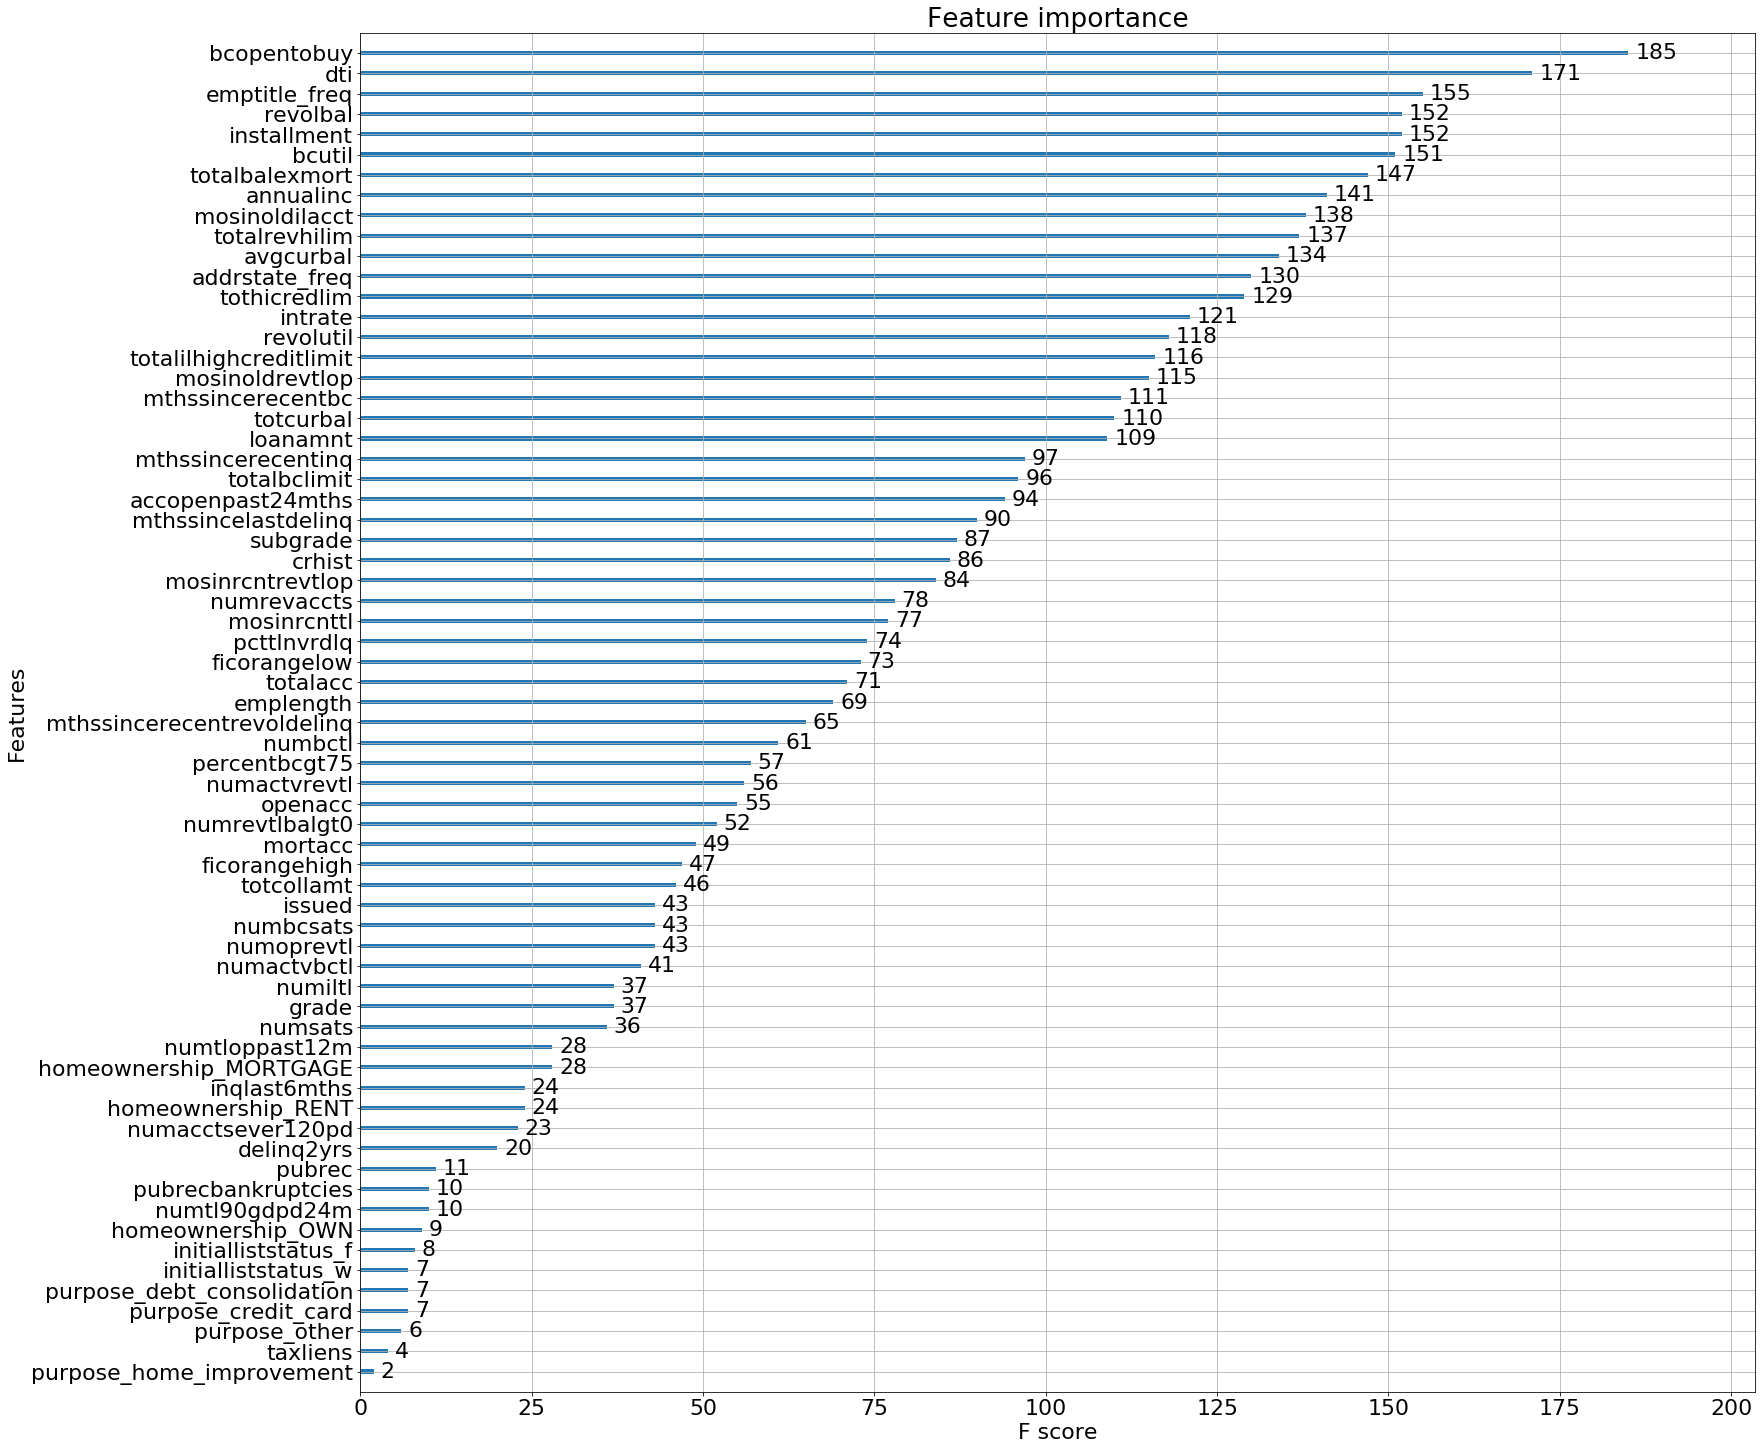

In [30]:
font = {'family' : 'DejaVu Sans',
#        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.rcParams["figure.figsize"] = (25,25)
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
xgb.plot_importance(bst_best)

**Visualize Gradiant Boosting Decision Trees:**

In [31]:
xgb.plot_tree(bst_best, num_trees=4, rankdir='LR')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 150)

**Prediction with Test Data**

In [40]:
pred = bst_best.predict(df_test.drop("loanstatus", axis = 1)) 

pred

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0])

**Reference:**
    
early stopping: https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
estimate the progress of GridSearchCV: https://stackoverflow.com/questions/43398909/how-to-estimate-the-progress-of-a-gridsearchcv-from-verbose-output-in-scikit-lea
unbalanced sample: https://stackoverflow.com/questions/49151325/how-to-penalize-false-negatives-more-than-false-positives

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification